# Purpose
arrange data for analysis. Datasets for each crystal condition have the following HDF5 formats:

```
/root
    /run_info
        /number_of_shots
    /data
        /detector_images
    /instruments_info
        /timing_monitor
            /delay_time
        /xray_source
            /source_type = virtual_XFEL
            /source_name = none
            /xray_wavelength
        /xray_imaging_detector
            /detector_type = virtual_detector
            /detector_name = none
            /momentum_space
                /momentum_x
                /momentum_y
    /sample_info
        /sample_name = xenon_cluster
        /sample_type = nanoscale_crystal
```

## setup modules

In [1]:
import copy
import glob
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import scipy.interpolate as interp
import os
import time
from typing import Tuple, Union, Dict

%matplotlib inline

## functions

In [2]:
def print_h5_tree(val, pre=''):
    if isinstance(val, h5py._hl.files.File):
        print(val.filename)

    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if isinstance(val, h5py._hl.group.Group):
                print(pre + '└── ' + key)
                print_h5_tree(val, pre+'    ')
            else:
                print(pre + '└── ' + key)
        else:
            if isinstance(val, h5py._hl.group.Group):
                print(pre + '├── ' + key)
                print_h5_tree(val, pre+'│   ')
            else:
                print(pre + '├── ' + key)


def print_h5_tree_from_path(fpath: str):
    with h5py.File(fpath, "r") as tree:
        print_h5_tree(tree)

In [3]:
def add_params(group, key, values):
    if values.get('value') is not None:
        _ = group.create_dataset(key, data=values['value'])
        return group
    group_ = group.create_group(f'{key}')
    for key_, values_ in values.items():
        group_ = add_params(group_, key_, values_)
    return group


def output(dstpath: str, output_dict: dict):
    with h5py.File(dstpath, 'w') as tree:
        for key in output_dict.keys():
            tree = add_params(tree, key, output_dict[key])

In [4]:
def update_dict_if_key_not_exist(
    dict_old: dict, dict_new: dict,
    overwrite_if_none: bool = False
) -> dict:
    if not isinstance(dict_new, dict):
        return dict_old
    for key in dict_new.keys():
        if key not in dict_old.keys():
            dict_old[key] = dict_new[key]
        if dict_old[key] is None and overwrite_if_none:
            dict_old[key] = dict_new[key]
        else:
            dict_old[key] = update_dict_if_key_not_exist(
                dict_old[key], dict_new[key]
            )
    return dict_old

In [17]:
def extract_xray_condition(tree):
    dst_ = {
        'source_type': {
            'value': 'virtual_XFEL',
            'unit': 'none',
            'type': 'str'
        },
        'source_name': {
            'value': 'none',
            'unit': 'none',
            'type': 'str'
        },
        'wavelength': {
            'value': tree['incident_xray_beam']['wavelength'][()],
            'unit': 'angstrom',
            'type': 'float'
        }
    }
    return {'xray_source': dst_}


def extract_detector_condition(tree):
    dst_ = {
        'detector_type': {
            'value': 'virtual_detector',
            'unit': 'none',
            'type': 'str'
        },
        'detector_name': {
            'value': 'none',
            'unit': 'none',
            'type': 'str'
        },
        'momentum_space': {
            'momentum_x': {
                'value': tree['momentum_space']['momentum_x'][()],
                'unit': 'none',
                'type': 'numpy.ndarray(numpy.float64)'
            },
            'momentum_y': {
                'value': tree['momentum_space']['momentum_y'][()],
                'unit': '1/angstrom',
                'type': 'numpy.ndarray(numpy.float64)'
            }
        }
    }
    return {'xray_imaging_detector': dst_}


def extract_sample_condition(tree):
    dst_ = {
        'sample_name': {
            'value': 'xenon_cluster',
            'unit': 'none',
            'type': 'str'
        },
        'sample_type': {
            'value': 'nanoscale_crystal',
            'unit': 'none',
            'type': 'str'
        }
    }
    return {'sample_info': dst_}


def extract_raw_simulation_condition(fpath: str, dst: dict = None) -> dict:
    if dst is None:
        dst = {
            'run_info': {},
            'data': {},
            'instruments_info': {},
            'sample_info': {},
        }

    with h5py.File(fpath, "r") as tree:
        dst_ = extract_xray_condition(tree['input_parameters'])
        dst['instruments_info'] = update_dict_if_key_not_exist(
            dst['instruments_info'], dst_
        )

        dst_ = extract_detector_condition(tree['outputs'])
        dst['instruments_info'] = update_dict_if_key_not_exist(
            dst['instruments_info'], dst_
        )

        dst_ = extract_sample_condition(tree['input_parameters'])
        dst = update_dict_if_key_not_exist(
            dst, dst_
        )
    
    return dst

In [29]:
def extract_experiment_condition(tree):
    dst_ = {
        'number_of_shots': {
            'value': tree['image']['number_of_images'][()],
            'unit': 'none',
            'type': 'int'
        }
    }
    return {'run_info': dst_}


def extract_experimental_results(tree):
    dst_ = {
        'detector_images': {
            'value': tree['main_outputs']['images'][()],
            'unit': 'photons',
            'type': 'numpy.ndarray(numpy.float64)'
        }
    }
    return {'data': dst_}


def extract_timing_monitor_results(tree):
    dst_ = {
        'delay_time': {
            'value': tree['timing_monitor']['delay_time'][()],
            'unit': 'femtosecond',
            'type': 'float'
        }
    }
    return { 'timing_monitor': dst_ }


def extract_experiment_cond_and_results(fpath: str, fpath_delay: str, dst: dict = None) -> dict:
    if dst is None:
        dst = {
            'run_info': {},
            'data': {},
            'instruments_info': {},
            'sample_info': {},
        }

    with h5py.File(fpath, "r") as tree:
        dst_ = extract_experiment_condition(tree['input_parameters'])
        dst = update_dict_if_key_not_exist(dst, dst_)
        dst_ = extract_experimental_results(tree['outputs'])
        dst = update_dict_if_key_not_exist(dst, dst_)
    
    with h5py.File(fpath_delay, "r") as tree:
        dst_ = extract_timing_monitor_results(tree)
        dst['instruments_info'] = update_dict_if_key_not_exist(dst['instruments_info'], dst_)
        
    return dst

## paths

In [11]:
# conditions to generate raw Bragg spots
srcdir = "../output_data/01_simulation/"
srclist = sorted(glob.glob(os.path.join(srcdir, "*.h5")))

# "experimental" results
expdir = "../output_data/03_calculate_exp_data/"
expfname = 'images_R{0:.2f}A_{1}shots.h5'

# delay time
delaydir = "../output_data/04_simulate_delay_time/"
delayfname = 'delay_time_R{0:.2f}A.h5'

# output
outputdir = "../output_data/05_arrange_data"
fname_fmt = 'exp_results_R{0:.2f}A.h5'
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

## get radii

In [12]:
radii = []
for fpath in srclist:
    with h5py.File(fpath, "r") as tree:
        radii.append(tree['input_parameters']['target']['crystal_characteristic_length'][()])

radii = np.array(radii)

## test to extract information

In [30]:
index = 2

exppath = sorted(glob.glob(
    os.path.join(expdir, 'images_R{0:.2f}*.h5'.format(radii[index]))
))[0]
delaypath = sorted(glob.glob(
    os.path.join(delaydir, 'delay_time_R{0:.2f}*.h5'.format(radii[index]))
))[0]
dst = extract_raw_simulation_condition(srclist[index])
dst = extract_experiment_cond_and_results(exppath, delaypath, dst)

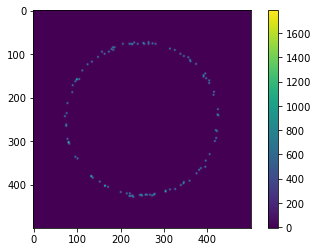

In [31]:
plt.imshow(dst['data']['detector_images']['value'].sum(axis=0))
plt.colorbar()

# main

In [32]:
%%time

for ii, srcpath in enumerate(srclist):
    radius_ = radii[ii]
    exppath = sorted(glob.glob(
        os.path.join(expdir, 'images_R{0:.2f}*.h5'.format(radius_))
    ))[0]
    delaypath = sorted(glob.glob(
        os.path.join(delaydir, 'delay_time_R{0:.2f}*.h5'.format(radii[index]))
    ))[0]
    
    # extract
    dst = extract_raw_simulation_condition(srcpath)
    dst = extract_experiment_cond_and_results(exppath, delaypath, dst)
    
    # output
    dstpath = os.path.join(outputdir, fname_fmt.format(radius_))
    output(dstpath, dst)

CPU times: user 209 ms, sys: 6.7 s, total: 6.91 s
Wall time: 11.2 s


## check the outputs

In [33]:
outputlist = sorted(glob.glob(os.path.join(outputdir, "*.h5")))

print_h5_tree_from_path(outputlist[0])

../output_data/05_arrange_data/exp_results_R10.40A.h5
├── data
│   └── detector_images
├── instruments_info
│   ├── timing_monitor
│   │   └── delay_time
│   ├── xray_imaging_detector
│   │   ├── detector_name
│   │   ├── detector_type
│   │   └── momentum_space
│   │       ├── momentum_x
│   │       └── momentum_y
│   └── xray_source
│       ├── source_name
│       ├── source_type
│       └── wavelength
├── run_info
│   └── number_of_shots
└── sample_info
    ├── sample_name
    └── sample_type


In [34]:
index = 2

image = None
with h5py.File(outputlist[index], "r") as tree:
    image = tree['data']['detector_images'][()].sum(axis=0)

In [35]:
def get_qrange(fpath: str) -> Tuple[Union[Dict[str, Union[Tuple[float], float]], float]]:
    qranges = {
        'x': None,  # (min, max)
        'y': None,  # (min, max)
    }
    dqs = {
        'x': None,
        'y': None,
    }
    with h5py.File(fpath, "r") as tree:
        momentum_space = tree['instruments_info']['xray_imaging_detector']['momentum_space']
        qranges['x'] = (
            momentum_space['momentum_x'][()].min(),
            momentum_space['momentum_x'][()].max()
        )
        qranges['y'] = (
            momentum_space['momentum_y'][()].min(),
            momentum_space['momentum_y'][()].max()
        ) 

        dqs['x'] = np.diff(sorted(np.unique(momentum_space['momentum_x'][()])))[0]
        dqs['y'] = np.diff(sorted(np.unique(momentum_space['momentum_y'][()])))[0]

    return qranges, dqs

In [36]:
qranges, dqs = get_qrange(outputlist[index])

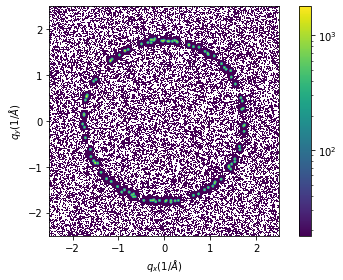

In [37]:
extent = [
    qranges['x'][0] - dqs['x'] / 2.0, qranges['x'][1] + dqs['x'] / 2.0,
    qranges['y'][0] - dqs['y'] / 2.0, qranges['y'][1] + dqs['y'] / 2.0
]  # (left, right, bottom, top)

plt.subplot(111)
plt.imshow(
    image, origin='lower', extent=extent,
    norm=LogNorm(vmin=image.max() / 1e2, vmax=image.max())
)

plt.xlabel('$q_x (1/\AA$)')
plt.ylabel('$q_y (1/\AA$)')

# plt.xlim(pos_spot_qranges['x'][0], pos_spot_qranges['x'][-1])
# plt.ylim(pos_spot_qranges['y'][0], pos_spot_qranges['y'][-1])
plt.colorbar()

plt.tight_layout()